In [ ]:
!git clone https://github.com//joaojtmarques/WEDA-FALL.git


Cloning into 'WEDA-FALL'...
remote: Enumerating objects: 14524, done.
remote: Counting objects: 100% (14524/14524), done.
remote: Compressing objects: 100% (14412/14412), done.
remote: Total 14524 (delta 118), reused 14501 (delta 111), pack-reused 0 (from 0)
Receiving objects: 100% (14524/14524), 26.58 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Updating files: 100% (15349/15349), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# zip_path = "/content/drive/MyDrive/GYROSCOPE_PROJECT/unzipped/GeoTecINIT/sp-sw-har-dataset-v1.0.0-r1.zip"
# extract_path = "/content/drive/MyDrive/GYROSCOPE_PROJECT/unzipped/"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("✅ Unzipped successfully to:", extract_path)


✅ Unzipped successfully to: /content/drive/MyDrive/GYROSCOPE_PROJECT/unzipped/


#MODEL EVALUATION ON WELLA DATASET

Processing activities:
ALL ACTIVITIES (D01-D11) are treated as HOME MOVEMENTS


Class distribution (all as Home Movements):
activity_label
Home_movements    5094
Name: count, dtype: int64

Original class distribution (all as Home Movements):
original_activity_label
Home_movements    5094
Name: count, dtype: int64

Window-level class distribution:
activity_label
Home_movements    527
Name: count, dtype: int64

Original window-level class distribution:
original_activity_label
Home_movements    527
Name: count, dtype: int64

Missing values before imputation:
total_acceleration_magnitude                   0
gyroscope_vector_magnitude                     0
total_acceleration_magnitude_min_per_window    0
mean_gyroscope_energy_per_window               0
mean_accelerometer_energy_per_window           0
angle_gx_gy                                    0
gyroscope_z_std_per_window                     0
dtype: int64

True label distribution:
original_activity_id
0    527
Name: count, dtype: int64


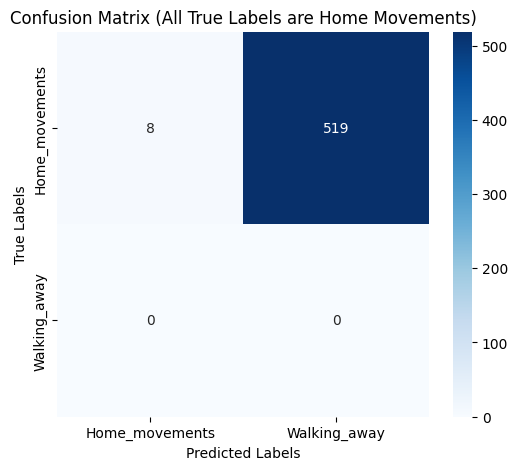

Results saved to 'corrected_features_with_predictions.csv'


In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.impute import SimpleImputer
import joblib
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define high-pass filter function
def butter_highpass_filter(data, cutoff_frequency, sampling_rate, order=5):
    """Apply a high-pass filter to the data."""
    nyquist_frequency = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# Calculate angle between vectors, handling zero norms
def angle(v1, v2):
    """
    Calculate the angle between two vectors in radians.
    Returns 0 if either vector has zero norm to avoid division by zero.
    """
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    cos_theta = np.dot(v1, v2) / (norm_v1 * norm_v2)
    return np.arccos(np.clip(cos_theta, -1, 1))

# Load and merge accelerometer and gyroscope data
def prepare_dataset(dataset_path):
    """Load and merge sensor data from CSV files, labeling all activities as 'Home_movements'."""
    dataframes = []
    activities = [f'D{i:02d}' for i in range(1, 12)]  # D01 to D11

    print("Processing activities:")
    print("ALL ACTIVITIES (D01-D11) are treated as HOME MOVEMENTS")
    print()

    for activity in activities:
        activity_path = os.path.join(dataset_path, activity)
        if not os.path.isdir(activity_path):
            print(f"Skipping {activity}: Directory not found")
            continue

        files = os.listdir(activity_path)
        accel_files = [f for f in files if f.endswith('_accel.csv')]

        for accel_file in accel_files:
            file_parts = accel_file.split('_')
            if len(file_parts) < 3:
                continue

            user_id = file_parts[0]
            trial_counter = file_parts[1]
            gyro_file = f'{user_id}_{trial_counter}_gyro.csv'

            if gyro_file not in files:
                continue

            accel_df = pd.read_csv(os.path.join(activity_path, accel_file))
            gyro_df = pd.read_csv(os.path.join(activity_path, gyro_file))

            accel_df = accel_df.rename(columns={
                'accel_time_list': 'time',
                'accel_x_list': 'accel_x',
                'accel_y_list': 'accel_y',
                'accel_z_list': 'accel_z'
            })
            gyro_df = gyro_df.rename(columns={
                'gyro_time_list': 'time',
                'gyro_x_list': 'gyro_x',
                'gyro_y_list': 'gyro_y',
                'gyro_z_list': 'gyro_z'
            })

            merged_df = pd.merge(accel_df, gyro_df, on='time', how='inner')
            if merged_df.empty:
                continue

            merged_df['activity'] = activity
            merged_df['user_id'] = user_id
            merged_df['trial_counter'] = trial_counter
            merged_df['trial_id'] = f'{activity}_{user_id}_{trial_counter}'
            merged_df['activity_id'] = 0  # All as Home Movements
            merged_df['activity_label'] = 'Home_movements'
            merged_df['original_activity_id'] = 0  # All original as Home Movements
            merged_df['original_activity_label'] = 'Home_movements'

            dataframes.append(merged_df)

    if not dataframes:
        return pd.DataFrame()

    full_df = pd.concat(dataframes, ignore_index=True)
    print("\nClass distribution (all as Home Movements):")
    print(full_df['activity_label'].value_counts())
    print("\nOriginal class distribution (all as Home Movements):")
    print(full_df['original_activity_label'].value_counts())
    return full_df

# Preprocess data with filtering and magnitude calculations
def preprocess_data(df, sampling_rate=10, cutoff_frequency=0.5):
    """Apply high-pass filter and compute acceleration and gyroscope magnitudes."""
    for col in ['accel_x', 'accel_y', 'accel_z']:
        df[col] = butter_highpass_filter(df[col], cutoff_frequency, sampling_rate)
    df['total_acceleration_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)
    df['gyroscope_vector_magnitude'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)
    return df

# Apply windowing to segment data
def apply_windowing(df, window_duration=5, overlap_fraction=0.5, sampling_rate=10):
    """Segment data into overlapping windows, excluding windows with fewer than 2 samples."""
    window_size = int(window_duration * sampling_rate)
    overlap = int(window_size * overlap_fraction)
    windows = []

    for trial_id, trial_df in df.groupby('trial_id'):
        trial_length = len(trial_df)
        if trial_length >= window_size:
            start = 0
            while start + window_size <= trial_length:
                end = start + window_size
                window_df = trial_df.iloc[start:end].copy()
                if len(window_df) >= 2:  # Ensure at least 2 samples
                    window_df['window_id'] = f"{trial_id}_{start}"
                    windows.append(window_df)
                start += window_size - overlap
        else:
            if trial_length >= 2:  # Only include if at least 2 samples
                window_df = trial_df.copy()
                window_df['window_id'] = f"{trial_id}_0"
                windows.append(window_df)

    return pd.concat(windows, ignore_index=True)

# Compute features for each window
def compute_features(df):
    """Extract features from each window for classification."""
    features = []
    for window_id, window_df in df.groupby('window_id'):
        feature_dict = {
            'window_id': window_id,
            'total_acceleration_magnitude': window_df['total_acceleration_magnitude'].mean(),
            'gyroscope_vector_magnitude': window_df['gyroscope_vector_magnitude'].mean(),
            'total_acceleration_magnitude_min_per_window': window_df['total_acceleration_magnitude'].min(),
            'mean_accelerometer_energy_per_window': (window_df['accel_x']**2 + window_df['accel_y']**2 + window_df['accel_z']**2).mean(),
            'mean_gyroscope_energy_per_window': (window_df['gyro_x']**2 + window_df['gyro_y']**2 + window_df['gyro_z']**2).mean(),
            'angle_gx_gy': angle(window_df['gyro_x'].values, window_df['gyro_y'].values),
            'gyroscope_z_std_per_window': window_df['gyro_z'].std(),
            'activity_id': window_df['activity_id'].iloc[0],
            'activity_label': window_df['activity_label'].iloc[0],
            'original_activity_id': window_df['original_activity_id'].iloc[0],
            'original_activity_label': window_df['original_activity_label'].iloc[0]
        }
        features.append(feature_dict)

    features_df = pd.DataFrame(features)
    print("\nWindow-level class distribution:")
    print(features_df['activity_label'].value_counts())
    print("\nOriginal window-level class distribution:")
    print(features_df['original_activity_label'].value_counts())
    return features_df

# Main execution block
if __name__ == '__main__':
    dataset_path = '/content/WEDA-FALL/dataset/10Hz'
    if not os.path.exists(dataset_path):
        print(f"ERROR: Dataset path {dataset_path} does not exist.")
    else:
        df = prepare_dataset(dataset_path)
        if not df.empty:
            df = preprocess_data(df)
            df = apply_windowing(df)
            features_df = compute_features(df)

            # Select features for prediction
            selected_features = [
                'total_acceleration_magnitude',
                'gyroscope_vector_magnitude',
                'total_acceleration_magnitude_min_per_window',
                'mean_gyroscope_energy_per_window',
                'mean_accelerometer_energy_per_window',
                'angle_gx_gy',
                'gyroscope_z_std_per_window'
            ]

            X_new = features_df[selected_features]
            y_true = features_df['original_activity_id']  # All Home Movements (0)

            # Check for missing values before imputation
            print("\nMissing values before imputation:")
            print(X_new.isna().sum())

            # Impute missing values
            imputer = SimpleImputer(strategy='mean')
            X_new_imputed = imputer.fit_transform(X_new)

            # Check for NaNs after imputation
            if np.isnan(X_new_imputed).any():
                print("Warning: NaN values present after imputation")

            # Load and predict with pre-trained model
            model_path = '/content/drive/MyDrive/GYROSCOPE_PROJECT/xgb_classifier.pkl'
            if os.path.exists(model_path):
                model = joblib.load(model_path)
                y_pred = model.predict(X_new_imputed)

                # Print distributions to confirm misclassifications
                print("\nTrue label distribution:")
                print(pd.Series(y_true).value_counts())
                print("Prediction distribution:")
                print(pd.Series(y_pred).value_counts())

                # Check for misclassifications
                if 1 in y_pred:
                    print("Model is predicting some 'Walking Away' instances (misclassifications detected).")
                else:
                    print("Model is predicting all as 'Home Movements' (no misclassifications).")

                # Evaluate predictions
                accuracy = accuracy_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred, average='weighted')
                conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

                print(f"\nAccuracy: {accuracy:.4f}")
                print(f"F1 Score: {f1:.4f}")
                print(f"Correct predictions (Home Movements): {sum((y_true == 0) & (y_pred == 0))}")
                print(f"Misclassifications as Walking Away: {sum((y_true == 0) & (y_pred == 1))}")

                # Plot confusion matrix with both classes
                plt.figure(figsize=(6, 5))
                sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                            xticklabels=['Home_movements', 'Walking_away'],
                            yticklabels=['Home_movements', 'Walking_away'])
                plt.xlabel('Predicted Labels')
                plt.ylabel('True Labels')
                plt.title('Confusion Matrix (All True Labels are Home Movements)')
                plt.show()

                # Save results
                features_df['predicted_activity_id'] = y_pred
                features_df['predicted_activity_label'] = ['Home_movements' if pred == 0 else 'Walking_away' for pred in y_pred]
                features_df.to_csv('corrected_features_with_predictions.csv', index=False)
                print("Results saved to 'corrected_features_with_predictions.csv'")

#MODEL TEST ON IPIN2017_public_datasets(ONLY WALKING AWAY)

=== STANDARDIZED PIPELINE FOR IPIN2017 DATASET ===
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Step 1: Data Acquisition - Extracting archive...
✅ RAR already extracted
Step 1: Data Acquisition - Loading raw sensor files...
✅ Loaded 1623384 records from 29 trials
✅ Subjects found: ['2017-03-23', '2017-04-03', '2017-04-10', '2017-04-11', '2017-04-12', '2017-04-13']
Step 2: Standardized Preprocessing...
  Processing trial: 2017-04-13_10-26-08
  Applying high-pass filtering to trial 2017-04-13_10-26-08...
  ✅ Trial 2017-04-13_10-26-08: 1674 samples at 10Hz
  Processing trial: 2017-04-10_10-54-25
  Applying high-pass filtering to trial 2017-04-10_10-54-25...
  ✅ Trial 2017-04-10_10-54-25: 2933 samples at 10Hz
  Processing trial: 2017-04-10_14-15-35
  Applying high-pass filtering to trial 2017-04-10_14-15-35...
  ✅ Trial 2017-04-10_14-15-35: 2061 samples at 10Hz
  Processing trial: 2017-04-13_11-01-33
  Appl

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


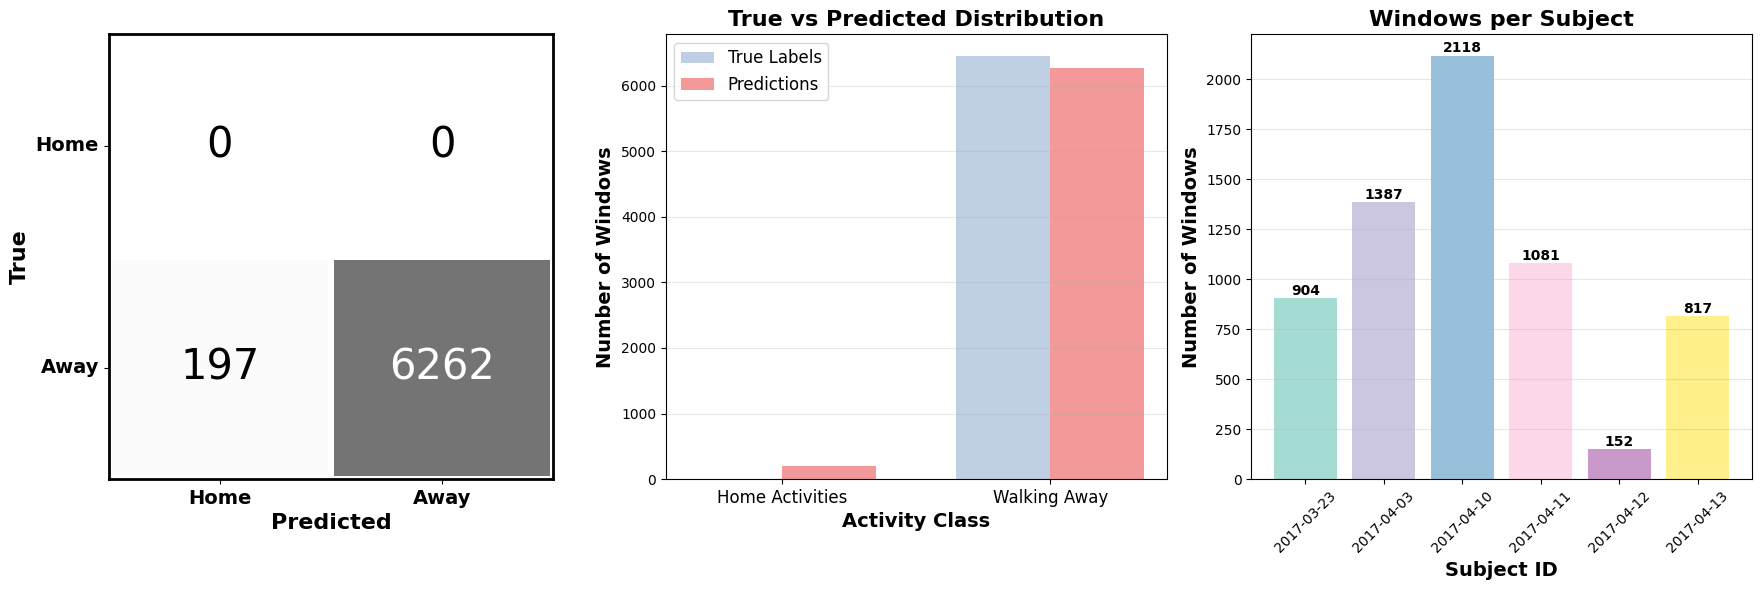


=== DETAILED DATA ANALYSIS ===
Total windows: 6459
True label 0 (Home): 0 windows
True label 1 (Away): 6459 windows
Predicted label 0 (Home): 197 windows
Predicted label 1 (Away): 6262 windows

✅ Results saved to 'ipin2017_standardized_results.csv'

=== ADDITIONAL ANALYSIS ===
Per-trial accuracy range: 0.8493 - 0.9978
Trials with 100% accuracy: 0/29

=== PIPELINE COMPLETE ===
✅ Applied standardized 5s windowing with 50% overlap
✅ Consistent preprocessing and feature extraction
✅ Same feature set as training pipeline
✅ Enhanced visualization with proper grey-scale confusion matrix
✅ Results ready for cross-dataset comparison


In [ ]:
!apt-get install unrar > /dev/null
!pip install rarfile > /dev/null

import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib
import rarfile
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def butter_highpass_filter(data, cutoff_frequency, sampling_rate, order=5):
    """Apply high-pass Butterworth filter to remove low-frequency drift"""
    nyquist_frequency = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def angle(v1, v2):
    """Calculate angle between two vectors with safety checks"""
    if len(v1) == 0 or len(v2) == 0:
        return 0.0

    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0

    cos_theta = np.dot(v1, v2) / (norm_v1 * norm_v2)
    return np.arccos(np.clip(cos_theta, -1, 1))

def load_inertia_wrist_files(dataset_path):
    """
    Step 1: Data Acquisition
    Load raw sensor files from all trial folders with consistent structure
    """
    print("Step 1: Data Acquisition - Loading raw sensor files...")

    dataframes = []
    trial_count = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file == 'inertial_measurements_wrist.csv':
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(file_path)

                    # Standardize column naming convention
                    df = df.rename(columns={
                        'systemTimeMillis': 'timestamp_ms',
                        'accX': 'accel_x',
                        'accY': 'accel_y',
                        'accZ': 'accel_z',
                        'gyrX': 'gyro_x',
                        'gyrY': 'gyro_y',
                        'gyrZ': 'gyro_z'
                    })

                    # Extract trial information
                    trial_id = os.path.basename(root)
                    df['trial_id'] = trial_id
                    df['subject_id'] = trial_id.split('_')[0] if '_' in trial_id else trial_id

                    # Add dataset identifier for consistency
                    df['dataset'] = 'IPIN2017'

                    dataframes.append(df)
                    trial_count += 1

                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"✅ Loaded {len(combined_df)} records from {trial_count} trials")
        print(f"✅ Subjects found: {sorted(combined_df['subject_id'].unique())}")
        return combined_df
    else:
        print("❌ No data files found")
        return pd.DataFrame()

def standardized_preprocessing(df, target_sampling_rate=10, cutoff_frequency=0.5):
    """
    Step 2: Standardized Preprocessing
    - Timestamp conversion
    - Resampling to consistent rate
    - Interpolation for missing values
    - High-pass filtering
    """
    print("Step 2: Standardized Preprocessing...")

    if df.empty:
        return df

    processed_trials = []

    for trial_id in df['trial_id'].unique():
        trial_df = df[df['trial_id'] == trial_id].copy()

        # Timestamp Conversion: Convert systemTimeMillis to datetime
        print(f"  Processing trial: {trial_id}")
        trial_df['datetime'] = pd.to_datetime(trial_df['timestamp_ms'], unit='ms')
        trial_df['timestamp'] = (trial_df['timestamp_ms'] - trial_df['timestamp_ms'].min()) / 1000.0  # Convert to seconds from start

        # Sort by timestamp to ensure proper ordering
        trial_df = trial_df.sort_values('timestamp').reset_index(drop=True)

        # Resampling: Resample to target sampling rate (10 Hz)
        trial_df = trial_df.set_index('datetime')

        # Select numeric columns for resampling
        numeric_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'timestamp_ms']
        non_numeric_cols = ['trial_id', 'subject_id', 'dataset']

        # Resample numeric data to 100ms intervals (10 Hz)
        resampled_numeric = trial_df[numeric_cols].resample('100ms').mean()

        # Interpolation: Fill missing time steps with interpolated values
        resampled_numeric = resampled_numeric.interpolate(method='linear')

        # Remove any remaining NaN values
        resampled_numeric = resampled_numeric.dropna()

        if len(resampled_numeric) == 0:
            print(f"  ⚠️ No data remaining after resampling for trial {trial_id}")
            continue

        # Reconstruct non-numeric columns
        resampled_df = resampled_numeric.reset_index()
        resampled_df['trial_id'] = trial_id
        resampled_df['subject_id'] = trial_df['subject_id'].iloc[0]
        resampled_df['dataset'] = 'IPIN2017'
        resampled_df['timestamp'] = (resampled_df['timestamp_ms'] - resampled_df['timestamp_ms'].min()) / 1000.0

        # High-pass Filtering: Remove low-frequency drift from accelerometer signals
        print(f"  Applying high-pass filtering to trial {trial_id}...")
        for col in ['accel_x', 'accel_y', 'accel_z']:
            if len(resampled_df[col]) > 10:  # Ensure minimum data for filtering
                try:
                    resampled_df[col] = butter_highpass_filter(
                        resampled_df[col].values,
                        cutoff_frequency,
                        target_sampling_rate
                    )
                except Exception as e:
                    print(f"  ⚠️ Filtering failed for {col} in trial {trial_id}: {e}")

        processed_trials.append(resampled_df)
        print(f"  ✅ Trial {trial_id}: {len(resampled_df)} samples at {target_sampling_rate}Hz")

    if processed_trials:
        final_df = pd.concat(processed_trials, ignore_index=True)
        print(f"✅ Preprocessing complete: {len(final_df)} total samples")
        return final_df
    else:
        print("❌ No trials successfully processed")
        return pd.DataFrame()

def feature_engineering(df):
    """
    Step 3: Feature Engineering
    Compute derived features consistently across datasets
    """
    print("Step 3: Feature Engineering...")

    if df.empty:
        return df

    # Compute derived features
    df['total_acceleration_magnitude'] = np.sqrt(
        df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2
    )
    df['gyroscope_vector_magnitude'] = np.sqrt(
        df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2
    )

    print("✅ Derived features computed")
    return df

def create_standardized_windows(df, window_duration=5, overlap_fraction=0.5, sampling_rate=10):
    """
    Step 4: Windowing
    Create fixed-size windows with specified duration and overlap
    """
    print(f"Step 4: Windowing - Creating {window_duration}s windows with {overlap_fraction*100}% overlap...")

    if df.empty:
        return pd.DataFrame()

    window_size = int(window_duration * sampling_rate)
    overlap_samples = int(window_size * overlap_fraction)
    step_size = window_size - overlap_samples

    windows = []
    total_windows = 0

    for trial_id in df['trial_id'].unique():
        trial_df = df[df['trial_id'] == trial_id].copy()
        trial_df = trial_df.sort_values('timestamp').reset_index(drop=True)

        trial_length = len(trial_df)
        trial_windows = 0

        if trial_length >= window_size:
            # Create overlapping windows
            for start in range(0, trial_length - window_size + 1, step_size):
                end = start + window_size
                window_df = trial_df.iloc[start:end].copy()
                window_df['window_id'] = f"{trial_id}_w{trial_windows}"
                window_df['window_start_time'] = window_df['timestamp'].iloc[0]
                windows.append(window_df)
                trial_windows += 1
        else:
            # Handle partial windows (pad or skip based on requirements)
            if trial_length >= window_size * 0.5:  # At least 50% of window size
                window_df = trial_df.copy()
                window_df['window_id'] = f"{trial_id}_w0_partial"
                window_df['window_start_time'] = window_df['timestamp'].iloc[0]
                windows.append(window_df)
                trial_windows += 1
                print(f"  ⚠️ Partial window for {trial_id}: {trial_length} samples")

        total_windows += trial_windows
        print(f"  Trial {trial_id}: {trial_windows} windows created")

    if windows:
        windowed_df = pd.concat(windows, ignore_index=True)
        print(f"✅ Created {total_windows} windows total")
        return windowed_df
    else:
        print("❌ No windows created")
        return pd.DataFrame()

def extract_window_features(df):
    """
    Step 4 (continued): Feature Extraction from Windows
    Extract statistical features per window using identical formulas
    """
    print("Step 4: Extracting features from windows...")

    if df.empty:
        return pd.DataFrame()

    features = []

    for window_id in df['window_id'].unique():
        window_df = df[df['window_id'] == window_id]

        if len(window_df) == 0:
            continue

        # Extract all required features using identical calculations
        feature_dict = {
            'window_id': window_id,
            'trial_id': window_df['trial_id'].iloc[0],
            'subject_id': window_df['subject_id'].iloc[0],
            'window_start_time': window_df['window_start_time'].iloc[0],

            # Core features (identical to training pipeline)
            'total_acceleration_magnitude': window_df['total_acceleration_magnitude'].mean(),
            'gyroscope_vector_magnitude': window_df['gyroscope_vector_magnitude'].mean(),
            'total_acceleration_magnitude_min_per_window': window_df['total_acceleration_magnitude'].min(),
            'mean_accelerometer_energy_per_window': (
                window_df['accel_x']**2 + window_df['accel_y']**2 + window_df['accel_z']**2
            ).mean(),
            'mean_gyroscope_energy_per_window': (
                window_df['gyro_x']**2 + window_df['gyro_y']**2 + window_df['gyro_z']**2
            ).mean(),
            'angle_gx_gy': angle(window_df['gyro_x'].values, window_df['gyro_y'].values),
            'gyroscope_z_std_per_window': window_df['gyro_z'].std(),

            # Ground truth label (assuming walking away for IPIN2017)
            'activity_id': 1,  # Walking Away
            'dataset': 'IPIN2017'
        }

        features.append(feature_dict)

    features_df = pd.DataFrame(features)
    print(f"✅ Extracted features from {len(features_df)} windows")
    return features_df

def plot_detailed_results(y_true, y_pred, features_df):
    """Enhanced visualization of results with improved grey-scale confusion matrix"""
    plt.figure(figsize=(18, 6))

    # Confusion Matrix with improved grey shades
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Print actual confusion matrix values for debugging
    print(f"\nActual Confusion Matrix:")
    print(f"True labels distribution: {np.bincount(y_true)}")
    print(f"Predicted labels distribution: {np.bincount(y_pred)}")
    print(f"Confusion Matrix:\n{cm}")

    # Create custom grey colormap from white to medium grey
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['#FFFFFF', '#747474']  # White to rgb(116,116,116)
    cmap = LinearSegmentedColormap.from_list('custom_grey', colors, N=100)

    # Create the heatmap without annotations
    ax1 = sns.heatmap(cm, annot=False, cmap=cmap,
                      xticklabels=['Home', 'Away'],
                      yticklabels=['Home', 'Away'],
                      cbar=False, square=True, linewidths=3, linecolor='white',
                      vmin=0, vmax=cm.max())

    # Add manual annotations with dynamic text color
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            if cm.max() > 0:
                t = v / cm.max()
            else:
                t = 0
            # Calculate luminance
            luminance = 1 - t * (139 / 255)
            text_color = 'white' if luminance < 0.5 else 'black'
            ax1.text(j + 0.5, i + 0.5, str(v),
                     ha='center', va='center',
                     color=text_color, fontsize=30, fontweight='normal')

    # Customize labels and title
    plt.xlabel('Predicted', fontsize=16, fontweight='bold')
    plt.ylabel('True', fontsize=16, fontweight='bold')
    # plt.title('Confusion Matrix', fontsize=18, fontweight='bold')

    # Customize tick labels
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold', rotation=0)

    # Add border around the confusion matrix
    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')

    # Prediction Distribution
    plt.subplot(1, 3, 2)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_true, counts_true = np.unique(y_true, return_counts=True)

    # Create comprehensive bar chart
    labels = ['Home Activities', 'Walking Away']
    pred_counts = [0, 0]
    true_counts = [0, 0]

    # Fill prediction counts
    for i, label_val in enumerate([0, 1]):
        if label_val in unique_pred:
            pred_counts[i] = counts_pred[list(unique_pred).index(label_val)]
        if label_val in unique_true:
            true_counts[i] = counts_true[list(unique_true).index(label_val)]

    x = np.arange(len(labels))
    width = 0.35

    plt.bar(x - width/2, true_counts, width, label='True Labels', color='lightsteelblue', alpha=0.8)
    plt.bar(x + width/2, pred_counts, width, label='Predictions', color='lightcoral', alpha=0.8)

    plt.xlabel('Activity Class', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Windows', fontsize=14, fontweight='bold')
    plt.title('True vs Predicted Distribution', fontsize=16, fontweight='bold')
    plt.xticks(x, labels, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Subject Distribution
    plt.subplot(1, 3, 3)
    subject_counts = features_df['subject_id'].value_counts().sort_index()
    colors_subjects = plt.cm.Set3(np.linspace(0, 1, len(subject_counts)))

    bars = plt.bar(range(len(subject_counts)), subject_counts.values, color=colors_subjects, alpha=0.8)
    plt.xlabel('Subject ID', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Windows', fontsize=14, fontweight='bold')
    plt.title('Windows per Subject', fontsize=16, fontweight='bold')
    plt.xticks(range(len(subject_counts)), subject_counts.index, rotation=45, fontsize=10)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print(f"\n=== DETAILED DATA ANALYSIS ===")
    print(f"Total windows: {len(y_true)}")
    print(f"True label 0 (Home): {sum(y_true == 0)} windows")
    print(f"True label 1 (Away): {sum(y_true == 1)} windows")
    print(f"Predicted label 0 (Home): {sum(y_pred == 0)} windows")
    print(f"Predicted label 1 (Away): {sum(y_pred == 1)} windows")

    if sum(y_pred == 0) == 0:
        print("\n⚠️  WARNING: Model is predicting only 'Away' class!")
        print("   This suggests potential issues with:")
        print("   - Feature scaling/normalization differences")
        print("   - Model decision threshold")
        print("   - Feature distribution mismatch with training data")

def main():
    """
    Main execution function implementing the standardized pipeline
    """
    print("=== STANDARDIZED PIPELINE FOR IPIN2017 DATASET ===")

    # Mount Google Drive
    drive.mount('/content/drive')

    # Step 1: Data Acquisition - Mount storage and extract data
    rar_path = '/content/drive/MyDrive/GYROSCOPE_PROJECT/IPIN2017_public_datasets (1).rar'
    extract_path = '/content/IPIN2017_public_datasets'

    print("Step 1: Data Acquisition - Extracting archive...")
    if not os.path.exists(extract_path):
        try:
            with rarfile.RarFile(rar_path) as rf:
                rf.extractall(extract_path)
            print("✅ RAR file extracted successfully")
        except Exception as e:
            print(f"❌ Error extracting RAR file: {e}")
            return
    else:
        print("✅ RAR already extracted")

    # Load raw sensor files
    dataset_path = os.path.join(extract_path, 'IPIN')
    if not os.path.exists(dataset_path):
        print(f"❌ Dataset path {dataset_path} does not exist")
        return

    df = load_inertia_wrist_files(dataset_path)
    if df.empty:
        print("❌ No data loaded")
        return

    # Step 2: Standardized Preprocessing
    df = standardized_preprocessing(df, target_sampling_rate=10, cutoff_frequency=0.5)
    if df.empty:
        print("❌ Preprocessing failed")
        return

    # Step 3: Feature Engineering
    df = feature_engineering(df)

    # Step 4: Windowing
    windowed_df = create_standardized_windows(
        df,
        window_duration=5,    # 5 seconds
        overlap_fraction=0.5,  # 50% overlap
        sampling_rate=10
    )

    if windowed_df.empty:
        print("❌ Windowing failed")
        return

    # Step 4 (continued): Feature Extraction
    features_df = extract_window_features(windowed_df)
    if features_df.empty:
        print("❌ Feature extraction failed")
        return

    # Step 5: Imputation
    print("Step 5: Imputation...")
    selected_features = [
        'total_acceleration_magnitude',
        'gyroscope_vector_magnitude',
        'total_acceleration_magnitude_min_per_window',
        'mean_gyroscope_energy_per_window',
        'mean_accelerometer_energy_per_window',
        'angle_gx_gy',
        'gyroscope_z_std_per_window'
    ]

    X_features = features_df[selected_features]
    y_true = features_df['activity_id']

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_features_imputed = imputer.fit_transform(X_features)

    print("✅ Imputation complete")
    print(f"Feature matrix shape: {X_features_imputed.shape}")
    print(f"Feature statistics:")
    for i, feature in enumerate(selected_features):
        print(f"  {feature}: mean={np.mean(X_features_imputed[:, i]):.4f}, std={np.std(X_features_imputed[:, i]):.4f}")

    # Step 6: Feature Selection (already done by selecting specific features)
    print("Step 6: Feature Selection - Using predefined feature set ✅")

    # Step 7: Inference
    print("Step 7: Model Inference...")
    model_path = '/content/drive/MyDrive/GYROSCOPE_PROJECT/xgb_classifier.pkl'

    if not os.path.exists(model_path):
        print(f"❌ Model file {model_path} not found")
        print("Please ensure the trained model is available at the specified path")
        return

    try:
        model = joblib.load(model_path)
        y_pred = model.predict(X_features_imputed)

        # Get prediction probabilities for analysis
        try:
            y_pred_proba = model.predict_proba(X_features_imputed)
            print(f"Prediction probabilities - Class 0 mean: {np.mean(y_pred_proba[:, 0]):.4f}")
            print(f"Prediction probabilities - Class 1 mean: {np.mean(y_pred_proba[:, 1]):.4f}")
        except:
            print("Model doesn't support probability prediction")

        print("✅ Model inference complete")
    except Exception as e:
        print(f"❌ Model loading/prediction failed: {e}")
        return

    # Step 8: Evaluation
    print("Step 8: Evaluation...")

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')

    # Display results
    print(f"\n=== MODEL PERFORMANCE (Standardized Pipeline) ===")
    print(f"Dataset: IPIN2017")
    print(f"Total Trials: {len(features_df['trial_id'].unique())}")
    print(f"Total Subjects: {len(features_df['subject_id'].unique())}")
    print(f"Subjects: {sorted(features_df['subject_id'].unique())}")
    print(f"Windows Created: {len(features_df)}")
    print(f"Window Duration: 5 seconds")
    print(f"Window Overlap: 50%")
    print(f"Sampling Rate: 10 Hz")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=['Home Activities', 'Walking Away']))

    # Plot results with enhanced visualization
    plot_detailed_results(y_true, y_pred, features_df)

    # Save results with additional analysis
    results_df = features_df.copy()
    results_df['predicted_activity'] = y_pred
    results_df['correct_prediction'] = (y_true == y_pred)

    # Add prediction probabilities if available
    try:
        results_df['prob_home'] = y_pred_proba[:, 0]
        results_df['prob_away'] = y_pred_proba[:, 1]
    except:
        pass

    results_df.to_csv('ipin2017_standardized_results.csv', index=False)
    print("\n✅ Results saved to 'ipin2017_standardized_results.csv'")

    # Additional analysis
    print(f"\n=== ADDITIONAL ANALYSIS ===")
    trial_accuracy = results_df.groupby('trial_id')['correct_prediction'].mean()
    print(f"Per-trial accuracy range: {trial_accuracy.min():.4f} - {trial_accuracy.max():.4f}")
    print(f"Trials with 100% accuracy: {sum(trial_accuracy == 1.0)}/{len(trial_accuracy)}")

    print("\n=== PIPELINE COMPLETE ===")
    print("✅ Applied standardized 5s windowing with 50% overlap")
    print("✅ Consistent preprocessing and feature extraction")
    print("✅ Same feature set as training pipeline")
    print("✅ Enhanced visualization with proper grey-scale confusion matrix")
    print("✅ Results ready for cross-dataset comparison")

if __name__ == '__main__':
    main()

#MODEL TEST ON UCI HAR dataset(ALL HOME ACTIVITIES)

=== STANDARDIZED PIPELINE FOR UCI HAR DATASET ===
Step 1: Data Acquisition...
Reconstructed 1318272 data points from 30 subjects

Step 2: Standardized Preprocessing...
Starting standardized preprocessing...
Resampling from 50Hz to 10Hz...


<ipython-input-5-1366286779>:142: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_resampled = df.groupby(['subject_id', 'activity_label', 'true_binary_label']).apply(


Applying high-pass filtering...

Step 3-4: Feature Engineering and Windowing...
Creating 5s windows with 50.0% overlap...
Subject 1.0: 8885 samples, 354 windows
Subject 2.0: 7734 samples, 308 windows
Subject 3.0: 8733 samples, 348 windows
Subject 4.0: 8117 samples, 323 windows
Subject 5.0: 7735 samples, 308 windows
Subject 6.0: 8323 samples, 331 windows
Subject 7.0: 7888 samples, 314 windows
Subject 8.0: 7196 samples, 286 windows
Subject 9.0: 7375 samples, 294 windows
Subject 10.0: 7529 samples, 300 windows
Subject 11.0: 8093 samples, 322 windows
Subject 12.0: 8194 samples, 326 windows
Subject 13.0: 8375 samples, 334 windows
Subject 14.0: 8271 samples, 329 windows
Subject 15.0: 8400 samples, 335 windows
Subject 16.0: 9372 samples, 373 windows
Subject 17.0: 9423 samples, 375 windows
Subject 18.0: 9320 samples, 371 windows
Subject 19.0: 9218 samples, 367 windows
Subject 20.0: 9064 samples, 361 windows
Subject 21.0: 10447 samples, 416 windows
Subject 22.0: 8221 samples, 327 windows
Subjec

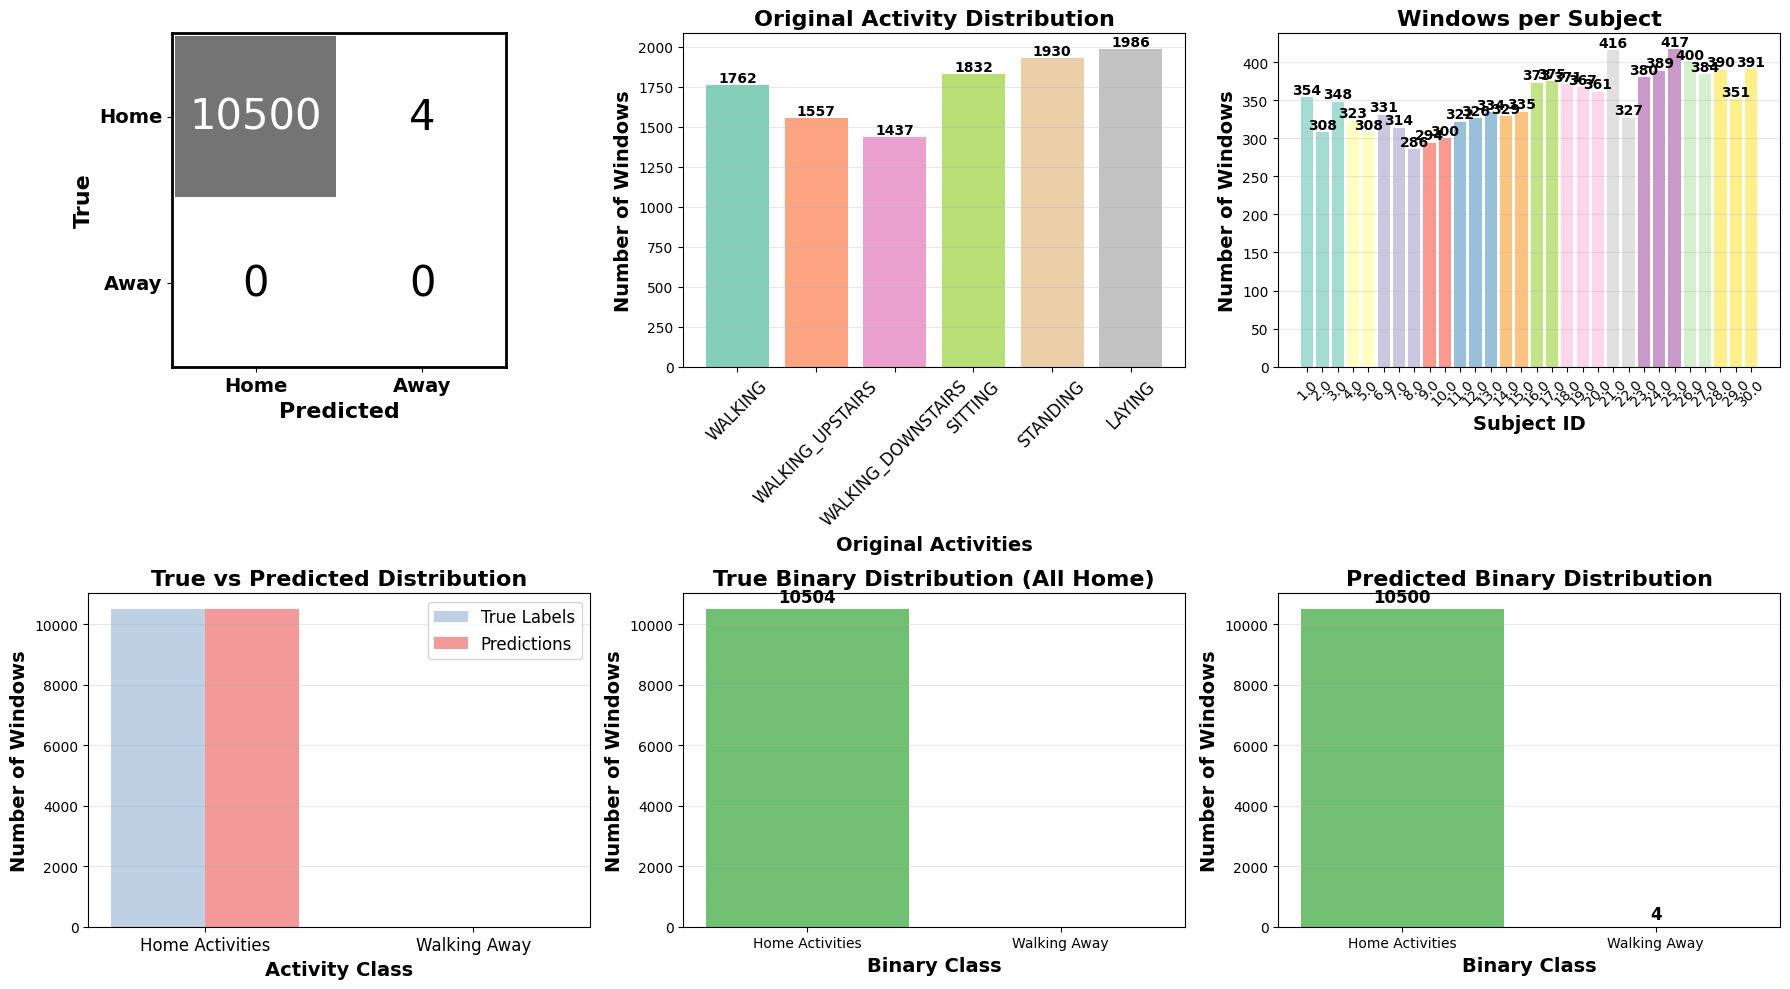


=== DETAILED DATA ANALYSIS ===
Total windows: 10504
True label 0 (Home): 10504 windows
True label 1 (Away): 0 windows
Predicted label 0 (Home): 10500 windows
Predicted label 1 (Away): 4 windows

⚠️  WARNING: Model misclassified some Home Activities as Away!
   Misclassifications: 4 windows
   Possible issues:
   - Feature scaling/normalization differences between training and test data
   - Model decision threshold may need adjustment
   - Feature distribution mismatch with training data

Results saved to 'uci_har_standardized_results_all_home.csv'


In [ ]:
# -*- coding: utf-8 -*-
"""
UCI HAR Dataset Model Testing Script - Standardized Pipeline Version
Modified to label all activities as 'Home Activities' for evaluation
Apply consistent 20s windowing pipeline to UCI Human Activity Recognition dataset
"""

import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta

# Define high-pass filter function
def butter_highpass_filter(data, cutoff_frequency, sampling_rate, order=5):
    """Apply high-pass Butterworth filter to remove low-frequency drift"""
    nyquist_frequency = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def angle(v1, v2):
    """Calculate angle between two vectors"""
    if len(v1) == 0 or len(v2) == 0:
        return 0.0
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_theta, -1, 1))

def reconstruct_continuous_signals(dataset_path):
    """
    Reconstruct continuous time series from UCI HAR pre-windowed data
    Returns: DataFrame with continuous sensor data and timestamps
    """
    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')
    train_inertial_path = os.path.join(train_path, 'Inertial Signals')
    test_inertial_path = os.path.join(test_path, 'Inertial Signals')

    # Load all signal files
    signal_files = [
        'body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt',
        'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
        'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt'
    ]

    test_signal_files = [f.replace('_train.txt', '_test.txt') for f in signal_files]

    # Load training data
    train_signals = {}
    for f in signal_files:
        filepath = os.path.join(train_inertial_path, f)
        if os.path.exists(filepath):
            train_signals[f] = np.loadtxt(filepath)

    # Load test data
    test_signals = {}
    for f in test_signal_files:
        filepath = os.path.join(test_inertial_path, f)
        if os.path.exists(filepath):
            test_signals[f] = np.loadtxt(filepath)

    # Load labels and subjects
    y_train = np.loadtxt(os.path.join(train_path, 'y_train.txt'))
    y_test = np.loadtxt(os.path.join(test_path, 'y_test.txt'))
    subject_train = np.loadtxt(os.path.join(train_path, 'subject_train.txt'))
    subject_test = np.loadtxt(os.path.join(test_path, 'subject_test.txt'))

    # Reconstruct continuous signals by concatenating windows
    continuous_data = []
    sampling_rate = 50  # Hz as specified in UCI HAR documentation
    window_size = 128   # readings per window

    # Process training data
    for i in range(len(y_train)):
        start_time = i * window_size / sampling_rate
        for j in range(window_size):
            timestamp = start_time + j / sampling_rate
            row = {
                'timestamp': timestamp,
                'subject_id': subject_train[i],
                'activity_label': y_train[i],
                'true_binary_label': 0,  # All activities labeled as Home (0)
                'dataset_split': 'train',
                'window_id': i,
                'body_acc_x': train_signals['body_acc_x_train.txt'][i, j],
                'body_acc_y': train_signals['body_acc_y_train.txt'][i, j],
                'body_acc_z': train_signals['body_acc_z_train.txt'][i, j],
                'body_gyro_x': train_signals['body_gyro_x_train.txt'][i, j],
                'body_gyro_y': train_signals['body_gyro_y_train.txt'][i, j],
                'body_gyro_z': train_signals['body_gyro_z_train.txt'][i, j],
                'total_acc_x': train_signals['total_acc_x_train.txt'][i, j],
                'total_acc_y': train_signals['total_acc_y_train.txt'][i, j],
                'total_acc_z': train_signals['total_acc_z_train.txt'][i, j]
            }
            continuous_data.append(row)

    # Process test data
    train_end_time = len(y_train) * window_size / sampling_rate
    for i in range(len(y_test)):
        start_time = train_end_time + i * window_size / sampling_rate
        for j in range(window_size):
            timestamp = start_time + j / sampling_rate
            row = {
                'timestamp': timestamp,
                'subject_id': subject_test[i],
                'activity_label': y_test[i],
                'true_binary_label': 0,  # All activities labeled as Home (0)
                'dataset_split': 'test',
                'window_id': len(y_train) + i,
                'body_acc_x': test_signals['body_acc_x_test.txt'][i, j],
                'body_acc_y': test_signals['body_acc_y_test.txt'][i, j],
                'body_acc_z': test_signals['body_acc_z_test.txt'][i, j],
                'body_gyro_x': test_signals['body_gyro_x_test.txt'][i, j],
                'body_gyro_y': test_signals['body_gyro_y_test.txt'][i, j],
                'body_gyro_z': test_signals['body_gyro_z_test.txt'][i, j],
                'total_acc_x': test_signals['total_acc_x_test.txt'][i, j],
                'total_acc_y': test_signals['total_acc_y_test.txt'][i, j],
                'total_acc_z': test_signals['total_acc_z_test.txt'][i, j]
            }
            continuous_data.append(row)

    return pd.DataFrame(continuous_data)

def standardized_preprocessing(df, target_sampling_rate=10):
    """
    Apply standardized preprocessing pipeline:
    1. Timestamp conversion
    2. Resampling to target rate
    3. Interpolation for missing values
    4. High-pass filtering
    """
    print("Starting standardized preprocessing...")
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    if target_sampling_rate < 50:
        print(f"Resampling from 50Hz to {target_sampling_rate}Hz...")
        df_resampled = df.groupby(['subject_id', 'activity_label', 'true_binary_label']).apply(
            lambda group: group.iloc[::int(50/target_sampling_rate)].copy()
        ).reset_index(drop=True)
    else:
        df_resampled = df.copy()

    print("Applying high-pass filtering...")
    for subject in df_resampled['subject_id'].unique():
        subject_mask = df_resampled['subject_id'] == subject
        subject_data = df_resampled[subject_mask].copy()
        if len(subject_data) > 10:
            acc_cols = ['body_acc_x', 'body_acc_y', 'body_acc_z']
            for col in acc_cols:
                filtered_signal = butter_highpass_filter(
                    subject_data[col].values,
                    cutoff_frequency=0.5,
                    sampling_rate=target_sampling_rate
                )
                df_resampled.loc[subject_mask, col] = filtered_signal

    return df_resampled

def create_standardized_windows(df, window_duration=5, overlap=0.5, sampling_rate=10):
    """
    Create fixed-size windows with specified duration and overlap
    """
    print(f"Creating {window_duration}s windows with {overlap*100}% overlap...")
    window_samples = int(window_duration * sampling_rate)
    step_samples = int(window_samples * (1 - overlap))
    windowed_data = []

    for subject in df['subject_id'].unique():
        subject_data = df[df['subject_id'] == subject].copy()
        subject_data = subject_data.sort_values('timestamp').reset_index(drop=True)
        num_windows = (len(subject_data) - window_samples) // step_samples + 1
        print(f"Subject {subject}: {len(subject_data)} samples, {num_windows} windows")
        for start_idx in range(0, len(subject_data) - window_samples + 1, step_samples):
            end_idx = start_idx + window_samples
            window_data = subject_data.iloc[start_idx:end_idx]
            if len(window_data) == window_samples:
                features = extract_window_features(window_data, window_samples)
                features['subject_id'] = subject
                features['window_start_time'] = window_data['timestamp'].iloc[0]
                features['activity_label'] = window_data['activity_label'].mode()[0]
                features['true_binary_label'] = 0  # All windows labeled as Home (0)
                windowed_data.append(features)

    return pd.DataFrame(windowed_data)

def extract_window_features(window_data, window_samples):
    """Extract standardized features from a single window"""
    acc_x = window_data['body_acc_x'].values
    acc_y = window_data['body_acc_y'].values
    acc_z = window_data['body_acc_z'].values
    gyro_x = window_data['body_gyro_x'].values
    gyro_y = window_data['body_gyro_y'].values
    gyro_z = window_data['body_gyro_z'].values

    total_acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    gyro_mag = np.sqrt(gyro_x**2 + gyro_y**2 + gyro_z**2)

    features = {
        'total_acceleration_magnitude': np.mean(total_acc_mag),
        'gyroscope_vector_magnitude': np.mean(gyro_mag),
        'total_acceleration_magnitude_min_per_window': np.min(total_acc_mag),
        'mean_accelerometer_energy_per_window': np.mean(acc_x**2 + acc_y**2 + acc_z**2),
        'mean_gyroscope_energy_per_window': np.mean(gyro_x**2 + gyro_y**2 + gyro_z**2),
        'angle_gx_gy': angle(gyro_x, gyro_y) if len(gyro_x) > 0 and len(gyro_y) > 0 else 0.0,
        'gyroscope_z_std_per_window': np.std(gyro_z)
    }

    return features

def plot_detailed_results(y_true, y_pred, features_df, original_labels=None):
    """Enhanced visualization of results with improved grey-scale confusion matrix"""
    plt.figure(figsize=(18, 10))

    # Confusion Matrix with custom styling (top left)
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Print actual confusion matrix values for debugging
    print(f"\nActual Confusion Matrix:")
    print(f"True labels distribution: {np.bincount(y_true)}")
    print(f"Predicted labels distribution: {np.bincount(y_pred)}")
    print(f"Confusion Matrix:\n{cm}")

    # Create custom grey colormap from white to rgb(116,116,116)
    colors = ['#FFFFFF', '#747474']  # White to rgb(116,116,116)
    cmap = LinearSegmentedColormap.from_list('custom_grey', colors, N=100)

    # Create the heatmap without annotations
    ax1 = sns.heatmap(cm, annot=False, cmap=cmap,
                      xticklabels=['Home', 'Away'],
                      yticklabels=['Home', 'Away'],
                      cbar=False, square=True, linewidths=3, linecolor='white',
                      vmin=0, vmax=cm.max())

    # Add manual annotations with dynamic text color
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            if cm.max() > 0:
                t = v / cm.max()
            else:
                t = 0
            # Calculate luminance
            luminance = 1 - t * (139 / 255)  # 139 = 255 - 116
            text_color = 'white' if luminance < 0.5 else 'black'
            ax1.text(j + 0.5, i + 0.5, str(v),
                     ha='center', va='center',
                     color=text_color, fontsize=30, fontweight='normal')

    # Customize labels and title
    plt.xlabel('Predicted', fontsize=16, fontweight='bold')
    plt.ylabel('True', fontsize=16, fontweight='bold')
    # plt.title('Confusion Matrix', fontsize=18, fontweight='bold')

    # Customize tick labels
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold', rotation=0)

    # Add border around the confusion matrix
    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')

    # Original activity distribution (top middle)
    if original_labels is not None:
        plt.subplot(2, 3, 2)
        unique_labels, counts = np.unique(original_labels, return_counts=True)
        activity_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS',
                          'SITTING', 'STANDING', 'LAYING']
        colors_activities = plt.cm.Set2(np.linspace(0, 1, len(unique_labels)))
        bars = plt.bar([activity_names[int(l)-1] for l in unique_labels], counts,
                      color=colors_activities, alpha=0.8)
        plt.xlabel('Original Activities', fontsize=14, fontweight='bold')
        plt.ylabel('Number of Windows', fontsize=14, fontweight='bold')
        plt.title('Original Activity Distribution', fontsize=16, fontweight='bold')
        plt.xticks(rotation=45, fontsize=12)
        plt.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Subject Distribution (top right)
    plt.subplot(2, 3, 3)
    subject_counts = features_df['subject_id'].value_counts().sort_index()
    colors_subjects = plt.cm.Set3(np.linspace(0, 1, len(subject_counts)))

    bars = plt.bar(range(len(subject_counts)), subject_counts.values,
                  color=colors_subjects, alpha=0.8)
    plt.xlabel('Subject ID', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Windows', fontsize=14, fontweight='bold')
    plt.title('Windows per Subject', fontsize=16, fontweight='bold')
    plt.xticks(range(len(subject_counts)), subject_counts.index, rotation=45, fontsize=10)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Binary Prediction Distribution (bottom left)
    plt.subplot(2, 3, 4)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_true, counts_true = np.unique(y_true, return_counts=True)

    # Create comprehensive bar chart
    labels = ['Home Activities', 'Walking Away']
    pred_counts = [0, 0]
    true_counts = [0, 0]

    # Fill prediction counts
    for i, label_val in enumerate([0, 1]):
        if label_val in unique_pred:
            pred_counts[i] = counts_pred[list(unique_pred).index(label_val)]
        if label_val in unique_true:
            true_counts[i] = counts_true[list(unique_true).index(label_val)]

    x = np.arange(len(labels))
    width = 0.35

    plt.bar(x - width/2, true_counts, width, label='True Labels', color='lightsteelblue', alpha=0.8)
    plt.bar(x + width/2, pred_counts, width, label='Predictions', color='lightcoral', alpha=0.8)

    plt.xlabel('Activity Class', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Windows', fontsize=14, fontweight='bold')
    plt.title('True vs Predicted Distribution', fontsize=16, fontweight='bold')
    plt.xticks(x, labels, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # True Binary Distribution (bottom middle)
    plt.subplot(2, 3, 5)
    binary_unique, binary_counts = np.unique(y_true, return_counts=True)
    labels = ['Home Activities', 'Walking Away']
    counts = [binary_counts[0] if 0 in binary_unique else 0,
              binary_counts[1] if 1 in binary_unique else 0]
    colors = ['#4CAF50', '#FF9800']  # Green for Home, Orange for Away
    plt.bar(labels, counts, color=colors, alpha=0.8)
    plt.xlabel('Binary Class', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Windows', fontsize=14, fontweight='bold')
    plt.title('True Binary Distribution (All Home)', fontsize=16, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, count in enumerate(counts):
        if count > 0:
            plt.text(i, count + max(counts)*0.01, f'{count}',
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Predicted Binary Distribution (bottom right)
    plt.subplot(2, 3, 6)
    pred_unique, pred_counts = np.unique(y_pred, return_counts=True)
    labels = ['Home Activities', 'Walking Away']
    counts = [pred_counts[0] if 0 in pred_unique else 0,
              pred_counts[1] if 1 in pred_unique else 0]
    colors = ['#4CAF50', '#FF9800']  # Green for Home, Orange for Away
    plt.bar(labels, counts, color=colors, alpha=0.8)
    plt.xlabel('Binary Class', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Windows', fontsize=14, fontweight='bold')
    plt.title('Predicted Binary Distribution', fontsize=16, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, count in enumerate(counts):
        if count > 0:
            plt.text(i, count + max(counts)*0.01, f'{count}',
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print(f"\n=== DETAILED DATA ANALYSIS ===")
    print(f"Total windows: {len(y_true)}")
    print(f"True label 0 (Home): {sum(y_true == 0)} windows")
    print(f"True label 1 (Away): {sum(y_true == 1)} windows")
    print(f"Predicted label 0 (Home): {sum(y_pred == 0)} windows")
    print(f"Predicted label 1 (Away): {sum(y_pred == 1)} windows")

    if sum(y_pred == 1) > 0 and sum(y_true == 0) == len(y_true):
        print("\n⚠️  WARNING: Model misclassified some Home Activities as Away!")
        print(f"   Misclassifications: {sum(y_pred == 1)} windows")
        print("   Possible issues:")
        print("   - Feature scaling/normalization differences between training and test data")
        print("   - Model decision threshold may need adjustment")
        print("   - Feature distribution mismatch with training data")

def main():
    """Main execution function implementing the standardized pipeline"""
    dataset_path = '/content/drive/MyDrive/GYROSCOPE_PROJECT/unzipped/UCI HAR Dataset'
    model_path = '/content/drive/MyDrive/GYROSCOPE_PROJECT/xgb_classifier.pkl'

    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist.")
        return

    print("=== STANDARDIZED PIPELINE FOR UCI HAR DATASET ===")
    print("Step 1: Data Acquisition...")
    continuous_df = reconstruct_continuous_signals(dataset_path)
    print(f"Reconstructed {len(continuous_df)} data points from {len(continuous_df['subject_id'].unique())} subjects")

    print("\nStep 2: Standardized Preprocessing...")
    preprocessed_df = standardized_preprocessing(continuous_df, target_sampling_rate=10)

    print("\nStep 3-4: Feature Engineering and Windowing...")
    windowed_features = create_standardized_windows(
        preprocessed_df,
        window_duration=5,
        overlap=0.5,
        sampling_rate=10
    )
    if len(windowed_features) == 0:
        print("No windows created. Check windowing parameters.")
        return
    print(f"Created {len(windowed_features)} windows")

    print("\nStep 5: Imputation...")
    selected_features = [
        'total_acceleration_magnitude',
        'gyroscope_vector_magnitude',
        'total_acceleration_magnitude_min_per_window',
        'mean_gyroscope_energy_per_window',
        'mean_accelerometer_energy_per_window',
        'angle_gx_gy',
        'gyroscope_z_std_per_window'
    ]
    X_features = windowed_features[selected_features]
    y_true = windowed_features['true_binary_label']
    original_labels = windowed_features['activity_label']

    imputer = SimpleImputer(strategy='mean')
    X_features_imputed = imputer.fit_transform(X_features)
    if np.isnan(X_features_imputed).any():
        print("Warning: NaN values in features after imputation")

    print("\nStep 6: Feature Selection - Using predefined feature set")

    print("\nStep 7: Model Inference...")
    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found.")
        return
    model = joblib.load(model_path)
    y_pred = model.predict(X_features_imputed)
    if np.isnan(y_pred).any():
        print("Warning: NaN values in predictions")
    print("Unique values in y_pred:", np.unique(y_pred))

    print("\nStep 8: Evaluation...")
    accuracy = accuracy_score(y_true, y_pred)
    # Compute F1 score only for Home class if only Home class exists
    if sum(y_true == 0) == len(y_true):
        f1 = f1_score(y_true, y_pred, average='binary', pos_label=0, zero_division=0)
    else:
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n=== MODEL PERFORMANCE ===")
    print(f"Windows Created: {len(windowed_features)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Home Activities): {f1:.4f}")
    false_positives = sum((y_true == 0) & (y_pred == 1))
    print(f"False Positives (Misclassified as Away): {false_positives}")

    print(f"\nClassification Report:")
    print("y_true unique values:", np.unique(y_true))
    print("y_pred unique values:", np.unique(y_pred))
    if sum(y_true == 0) == len(y_true):
        # Only Home class exists in y_true
        print("Note: Only Home Activities (0) present in true labels")
        precision = 1.0 if sum(y_pred == 0) > 0 else 0.0
        recall = sum((y_true == 0) & (y_pred == 0)) / sum(y_true == 0) if sum(y_true == 0) > 0 else 0.0
        f1_home = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        print("                  precision    recall  f1-score   support")
        print(f"Home Activities    {precision:.2f}      {recall:.2f}      {f1_home:.2f}     {sum(y_true == 0)}")
        print(f"Away               0.00      0.00      0.00         0")
        print(f"\naccuracy                            {accuracy:.2f}     {len(y_true)}")
        print(f"macro avg          {precision/2:.2f}      {recall/2:.2f}      {f1_home/2:.2f}     {len(y_true)}")
        print(f"weighted avg       {precision:.2f}      {recall:.2f}      {f1_home:.2f}     {len(y_true)}")
    else:
        try:
            print(classification_report(y_true, y_pred,
                                        labels=[0, 1],
                                        target_names=['Home Activities', 'Away'],
                                        zero_division=0))
        except ValueError as e:
            print(f"Error in classification report: {e}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Misclassifications: {sum(y_true != y_pred)}")

    # Use the improved visualization function
    plot_detailed_results(y_true, y_pred, windowed_features, original_labels)

    results_df = windowed_features.copy()
    results_df['predicted_binary'] = y_pred
    results_df.to_csv('uci_har_standardized_results_all_home.csv', index=False)
    print("\nResults saved to 'uci_har_standardized_results_all_home.csv'")

if __name__ == '__main__':
    main()

#MODEL EVALUATE ON GeoTecINIT(ALL HOME ACTIVITIEES)

🔧 Starting evaluation on GeoTecINIT Dataset - All Activities as Home Activities
📂 Loading GeoTecINIT dataset...
  Processing subject: s01
    Original columns: ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro', 'timestamp', 'label']
    Renamed columns: ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'time', 'label']
    ✅ Successfully loaded first file with 1351 samples
  Processing subject: s02
  Processing subject: s03
  Processing subject: s04
  Processing subject: s05
  Processing subject: s06
  Processing subject: s07
  Processing subject: s08
  Processing subject: s09
  Processing subject: s10
  Processing subject: s11
  Processing subject: s12
  Processing subject: s13
  Processing subject: s14
  Processing subject: s15
  Processing subject: s16
  Processing subject: s17
  Processing subject: s18
  Processing subject: s19
  Processing subject: s20
  Processing subject: s21
  Processing subject: s22
  Processing subject: s23
✅ Data loaded: (259213, 13)
Lab

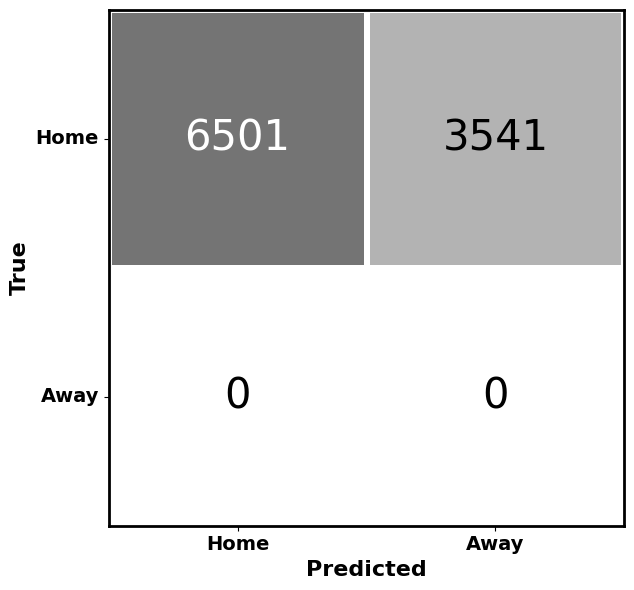


⚠️  WARNING: Model misclassified some Home Activities as Away!
   Misclassifications: 3541 windows
   Possible issues:
   - Feature scaling/normalization differences between training and test data
   - Model decision threshold may need adjustment
   - Feature distribution mismatch with training data

💾 Saving results...
✅ Results saved to 'geotecinit_all_home_evaluation_results.csv'

Class-specific analysis:
  Home correctly classified: 0.6474 (6501/10042)
  Home misclassified as Away: 3541 windows

EVALUATION COMPLETED SUCCESSFULLY! 🎉
Model tested for misclassification with all activities labeled as Home


In [ ]:
# -*- coding: utf-8 -*-
"""
GeoTecINIT Dataset Model Testing Script - Standardized Pipeline Version
Apply consistent 20s windowing pipeline, treating all activities as Home Activities
"""

import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# ========== FILTERING ==========
def butter_highpass_filter(data, cutoff_frequency, sampling_rate, order=5):
    """Apply high-pass Butterworth filter to remove DC component"""
    nyquist_frequency = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# ========== ANGLE FUNCTION ==========
def angle(v1, v2):
    """Calculate angle between two vectors"""
    if len(v1) == 0 or len(v2) == 0:
        return 0.0
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_theta, -1, 1))

# ========== LOAD GEOTECINIT DATA ==========
def load_geotecinit_dataset(dataset_path):
    """Load and preprocess GeoTecINIT dataset"""
    print("📂 Loading GeoTecINIT dataset...")
    all_data = []

    for subject_folder in sorted(os.listdir(dataset_path)):
        subject_path = os.path.join(dataset_path, subject_folder)
        if not os.path.isdir(subject_path):
            continue

        print(f"  Processing subject: {subject_folder}")

        for file in os.listdir(subject_path):
            if file.endswith("_sp.csv"):
                file_path = os.path.join(subject_path, file)
                try:
                    df = pd.read_csv(file_path)

                    # Debug: Print column names for first file
                    if len(all_data) == 0:
                        print(f"    Original columns: {list(df.columns)}")

                    # Rename columns to standard format
                    column_mapping = {
                        'x_acc': 'accel_x',
                        'y_acc': 'accel_y',
                        'z_acc': 'accel_z',
                        'x_gyro': 'gyro_x',
                        'y_gyro': 'gyro_y',
                        'z_gyro': 'gyro_z',
                        'timestamp': 'time'
                    }

                    # Only rename columns that exist
                    available_columns = {k: v for k, v in column_mapping.items() if k in df.columns}
                    df = df.rename(columns=available_columns)

                    if len(all_data) == 0:
                        print(f"    Renamed columns: {list(df.columns)}")

                    # Check if we have the required columns
                    required_accel_cols = ['accel_x', 'accel_y', 'accel_z']
                    required_gyro_cols = ['gyro_x', 'gyro_y', 'gyro_z']

                    missing_accel = [col for col in required_accel_cols if col not in df.columns]
                    missing_gyro = [col for col in required_gyro_cols if col not in df.columns]

                    if missing_accel:
                        print(f"    ⚠️  Missing accelerometer columns: {missing_accel}")
                        continue

                    if missing_gyro:
                        print(f"    ⚠️  Missing gyroscope columns: {missing_gyro}")
                        # Create dummy gyroscope data if missing
                        for col in missing_gyro:
                            df[col] = 0.0
                        print(f"    ✅ Created dummy gyroscope data")

                    # Metadata
                    df['trial_id'] = file.replace('.csv', '')
                    df['subject_id'] = subject_folder
                    df['activity_label_raw'] = df['label'] if 'label' in df.columns else 'unknown'

                    # Map all activities to Home Activities (0)
                    df['activity_id'] = 0
                    df['activity_label'] = 'Home'

                    all_data.append(df)

                    if len(all_data) == 1:
                        print(f"    ✅ Successfully loaded first file with {len(df)} samples")

                except Exception as e:
                    print(f"    ❌ Error loading {file_path}: {e}")

    if not all_data:
        raise ValueError("No data loaded. Check dataset path or file format.")

    full_df = pd.concat(all_data, ignore_index=True)
    print("✅ Data loaded:", full_df.shape)

    # Print label distribution
    if 'activity_label' in full_df.columns:
        print("Label distribution:")
        label_counts = full_df['activity_label'].value_counts()
        for label, count in label_counts.items():
            print(f"  {label}: {count}")

    # Print unique raw labels for reference
    if 'activity_label_raw' in full_df.columns:
        unique_raw_labels = full_df['activity_label_raw'].unique()
        print(f"Unique raw labels found: {list(unique_raw_labels)}")

    return full_df

# ========== PREPROCESS ==========
def preprocess_data(df, sampling_rate=10, cutoff_frequency=0.5):
    """Apply preprocessing: high-pass filter and magnitude calculations"""
    print("🔧 Preprocessing data...")

    # Apply high-pass filter to accelerometer data
    for col in ['accel_x', 'accel_y', 'accel_z']:
        if col in df.columns:
            df[col] = butter_highpass_filter(df[col], cutoff_frequency, sampling_rate)

    # Calculate magnitudes
    df['total_acceleration_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)

    # Only calculate gyroscope magnitude if gyroscope data exists
    if all(col in df.columns for col in ['gyro_x', 'gyro_y', 'gyro_z']):
        df['gyroscope_vector_magnitude'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)
    else:
        df['gyroscope_vector_magnitude'] = 0.0
        print("  ⚠️  Using dummy gyroscope magnitude (all zeros)")

    print("✅ Preprocessing complete")
    return df

# ========== WINDOWING ==========
def apply_windowing(df, window_duration=5, overlap_fraction=0.5, sampling_rate=10):
    """Apply sliding window segmentation"""
    print("🪟 Applying windowing...")

    window_size = int(window_duration * sampling_rate)
    overlap = int(window_size * overlap_fraction)
    windows = []

    print(f"  Window size: {window_size} samples ({window_duration}s)")
    print(f"  Overlap: {overlap} samples ({overlap_fraction*100}%)")

    for trial_id, trial_df in df.groupby('trial_id'):
        trial_length = len(trial_df)

        if trial_length >= window_size:
            start = 0
            window_count = 0
            while start + window_size <= trial_length:
                end = start + window_size
                window_df = trial_df.iloc[start:end].copy()
                window_df['window_id'] = f"{trial_id}_{start}"
                windows.append(window_df)
                start += window_size - overlap
                window_count += 1

            if window_count > 0:
                print(f"  {trial_id}: {window_count} windows from {trial_length} samples")
        else:
            # Handle short trials
            window_df = trial_df.copy()
            window_df['window_id'] = f"{trial_id}_0_partial"
            windows.append(window_df)
            print(f"  {trial_id}: 1 partial window from {trial_length} samples")

    if not windows:
        raise ValueError("No windows created. Check trial lengths and window parameters.")

    windowed_df = pd.concat(windows, ignore_index=True)
    total_windows = len(windowed_df['window_id'].unique())
    print(f"✅ Windowing complete: {total_windows} windows created")

    return windowed_df

# ========== FEATURE EXTRACTION ==========
def compute_features(df):
    """Extract features for each window"""
    print("🔍 Computing features...")

    features = []
    for window_id, window_df in df.groupby('window_id'):
        try:
            feature_dict = {
                'window_id': window_id,
                'total_acceleration_magnitude': window_df['total_acceleration_magnitude'].mean(),
                'gyroscope_vector_magnitude': window_df['gyroscope_vector_magnitude'].mean(),
                'total_acceleration_magnitude_min_per_window': window_df['total_acceleration_magnitude'].min(),
                'mean_accelerometer_energy_per_window': (window_df['accel_x']**2 + window_df['accel_y']**2 + window_df['accel_z']**2).mean(),
                'mean_gyroscope_energy_per_window': (window_df['gyro_x']**2 + window_df['gyro_y']**2 + window_df['gyro_z']**2).mean(),
                'gyroscope_z_std_per_window': window_df['gyro_z'].std(),
                'activity_id': window_df['activity_id'].iloc[0],
                'activity_label': window_df['activity_label'].iloc[0]
            }

            # Calculate angle between gyro_x and gyro_y if they exist and are not all zeros
            if (window_df['gyro_x'].sum() != 0 or window_df['gyro_y'].sum() != 0):
                feature_dict['angle_gx_gy'] = angle(window_df['gyro_x'].values, window_df['gyro_y'].values)
            else:
                feature_dict['angle_gx_gy'] = 0.0  # Default value for dummy gyro data

            features.append(feature_dict)

        except Exception as e:
            print(f"  ⚠️  Error computing features for window {window_id}: {e}")
            continue

    features_df = pd.DataFrame(features)
    print(f"✅ Feature extraction complete: {len(features_df)} feature vectors")

    # Print feature-level class distribution
    if 'activity_label' in features_df.columns:
        print("Window-level class distribution:")
        for label, count in features_df['activity_label'].value_counts().items():
            print(f"  {label}: {count} windows")

    return features_df

# ========== PLOT CONFUSION MATRIX ==========
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix with specified style"""
    plt.figure(figsize=(8, 6))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Print actual confusion matrix values for debugging
    print(f"\nActual Confusion Matrix:")
    print(f"True labels distribution: {np.bincount(y_true)}")
    print(f"Predicted labels distribution: {np.bincount(y_pred)}")
    print(f"Confusion Matrix:\n{cm}")

    # Create custom grey colormap from white to #747474
    colors = ['#FFFFFF', '#747474']
    cmap = LinearSegmentedColormap.from_list('custom_grey', colors, N=100)

    # Create the heatmap without annotations
    ax = sns.heatmap(cm, annot=False, cmap=cmap,
                     xticklabels=['Home', 'Away'],
                     yticklabels=['Home', 'Away'],
                     cbar=False, square=True, linewidths=3, linecolor='white',
                     vmin=0, vmax=cm.max())

    # Add manual annotations with dynamic text color
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            if cm.max() > 0:
                t = v / cm.max()
            else:
                t = 0
            # Calculate luminance
            luminance = 1 - t * (139 / 255)  # Since 139 = 255 - 116
            text_color = 'white' if luminance < 0.5 else 'black'
            ax.text(j + 0.5, i + 0.5, str(v),
                    ha='center', va='center',
                    color=text_color, fontsize=30, fontweight='normal')

    # Customize labels and title
    plt.xlabel('Predicted', fontsize=16, fontweight='bold')
    plt.ylabel('True', fontsize=16, fontweight='bold')
    # plt.title('Confusion Matrix - GeoTecINIT Dataset\n(All Activities Labeled as Home)', fontsize=18, fontweight='bold')

    # Customize tick labels
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold', rotation=0)

    # Add border around the confusion matrix
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')

    plt.tight_layout()
    plt.show()

    # Warning for misclassifications
    if sum(y_pred == 1) > 0 and sum(y_true == 0) == len(y_true):
        print("\n⚠️  WARNING: Model misclassified some Home Activities as Away!")
        print(f"   Misclassifications: {sum(y_pred == 1)} windows")
        print("   Possible issues:")
        print("   - Feature scaling/normalization differences between training and test data")
        print("   - Model decision threshold may need adjustment")
        print("   - Feature distribution mismatch with training data")

# ========== MAIN ==========
if __name__ == '__main__':
    # Paths - update these to match your environment
    dataset_path = '/content/drive/MyDrive/GYROSCOPE_PROJECT/unzipped/GeoTecINIT-sp-sw-har-dataset-25bcf90/DATA'
    model_path = '/content/drive/MyDrive/GYROSCOPE_PROJECT/xgb_classifier.pkl'

    print("🔧 Starting evaluation on GeoTecINIT Dataset - All Activities as Home Activities")
    print("="*60)

    try:
        # Step 1: Load dataset
        df = load_geotecinit_dataset(dataset_path)

        # Step 2: Preprocess
        df = preprocess_data(df)

        # Step 3: Apply windowing
        df = apply_windowing(df)

        # Step 4: Extract features
        features_df = compute_features(df)

        # Step 5: Prepare features for model
        selected_features = [
            'total_acceleration_magnitude',
            'gyroscope_vector_magnitude',
            'total_acceleration_magnitude_min_per_window',
            'mean_gyroscope_energy_per_window',
            'mean_accelerometer_energy_per_window',
            'angle_gx_gy',
            'gyroscope_z_std_per_window'
        ]

        print(f"\n🎯 Preparing features for prediction...")
        X = features_df[selected_features]
        y_true = features_df['activity_id']

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)
        print(f"  Feature matrix shape: {X_imputed.shape}")
        print(f"  True labels shape: {y_true.shape}")

        # Step 6: Load model and predict
        if not os.path.exists(model_path):
            print(f"❌ Model not found at {model_path}")
            print("Please verify the model path and try again.")
            exit()

        print(f"\n🤖 Loading model and making predictions...")
        model = joblib.load(model_path)
        y_pred = model.predict(X_imputed)

        # Step 7: Evaluate performance
        print(f"\n📊 Evaluating performance...")
        accuracy = accuracy_score(y_true, y_pred)
        # Compute F1 score only for Home class if only Home class exists
        if sum(y_true == 0) == len(y_true):
            f1 = f1_score(y_true, y_pred, average='binary', pos_label=0, zero_division=0)
        else:
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (Home Activities): {f1:.4f}")
        print(f"Total windows evaluated: {len(y_true)}")
        print(f"Correct predictions: {sum(y_true == y_pred)}")
        print(f"Incorrect predictions: {sum(y_true != y_pred)}")
        print("Note: All activities labeled as 'Home' (0) for testing model misclassification")

        # Classification Report
        print(f"\nClassification Report:")
        print("y_true unique values:", np.unique(y_true))
        print("y_pred unique values:", np.unique(y_pred))
        if sum(y_true == 0) == len(y_true):
            # Only Home class exists in y_true
            print("Note: Only Home Activities (0) present in true labels")
            precision = 1.0 if sum(y_pred == 0) > 0 else 0.0
            recall = sum((y_true == 0) & (y_pred == 0)) / sum(y_true == 0) if sum(y_true == 0) > 0 else 0.0
            f1_home = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
            print("                  precision    recall  f1-score   support")
            print(f"Home Activities    {precision:.2f}      {recall:.2f}      {f1_home:.2f}     {sum(y_true == 0)}")
            print(f"Away               0.00      0.00      0.00         0")
            print(f"\naccuracy                            {accuracy:.2f}     {len(y_true)}")
            print(f"macro avg          {precision/2:.2f}      {recall/2:.2f}      {f1_home/2:.2f}     {len(y_true)}")
            print(f"weighted avg       {precision:.2f}      {recall:.2f}      {f1_home:.2f}     {len(y_true)}")
        else:
            try:
                print(classification_report(y_true, y_pred,
                                            labels=[0, 1],
                                            target_names=['Home Activities', 'Away'],
                                            zero_division=0))
            except ValueError as e:
                print(f"Error in classification report: {e}")
                print(f"Accuracy: {accuracy:.4f}")
                print(f"Misclassifications: {sum(y_true != y_pred)}")

        # Plot confusion matrix with updated style
        plot_confusion_matrix(y_true, y_pred)

        # Step 8: Save results
        print(f"\n💾 Saving results...")
        features_df['predicted_activity_id'] = y_pred
        features_df['predicted_activity_label'] = ['Away' if i == 1 else 'Home' for i in y_pred]
        features_df['correct_prediction'] = (y_true == y_pred)

        output_file = 'geotecinit_all_home_evaluation_results.csv'
        features_df.to_csv(output_file, index=False)
        print(f"✅ Results saved to '{output_file}'")

        # Summary statistics
        correct_home = sum((y_true == 0) & (y_pred == 0))
        total_home = sum(y_true == 0)

        if total_home > 0:
            home_accuracy = correct_home / total_home
            misclassified_as_walking = sum((y_true == 0) & (y_pred == 1))
            print(f"\nClass-specific analysis:")
            print(f"  Home correctly classified: {home_accuracy:.4f} ({correct_home}/{total_home})")
            print(f"  Home misclassified as Away: {misclassified_as_walking} windows")

        print("\n" + "="*60)
        print("EVALUATION COMPLETED SUCCESSFULLY! 🎉")
        print("Model tested for misclassification with all activities labeled as Home")
        print("="*60)

    except Exception as e:
        print(f"\n❌ Error during evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
        print("\nPlease check your dataset path, file format, and try again.")